# Flight Price Prediction

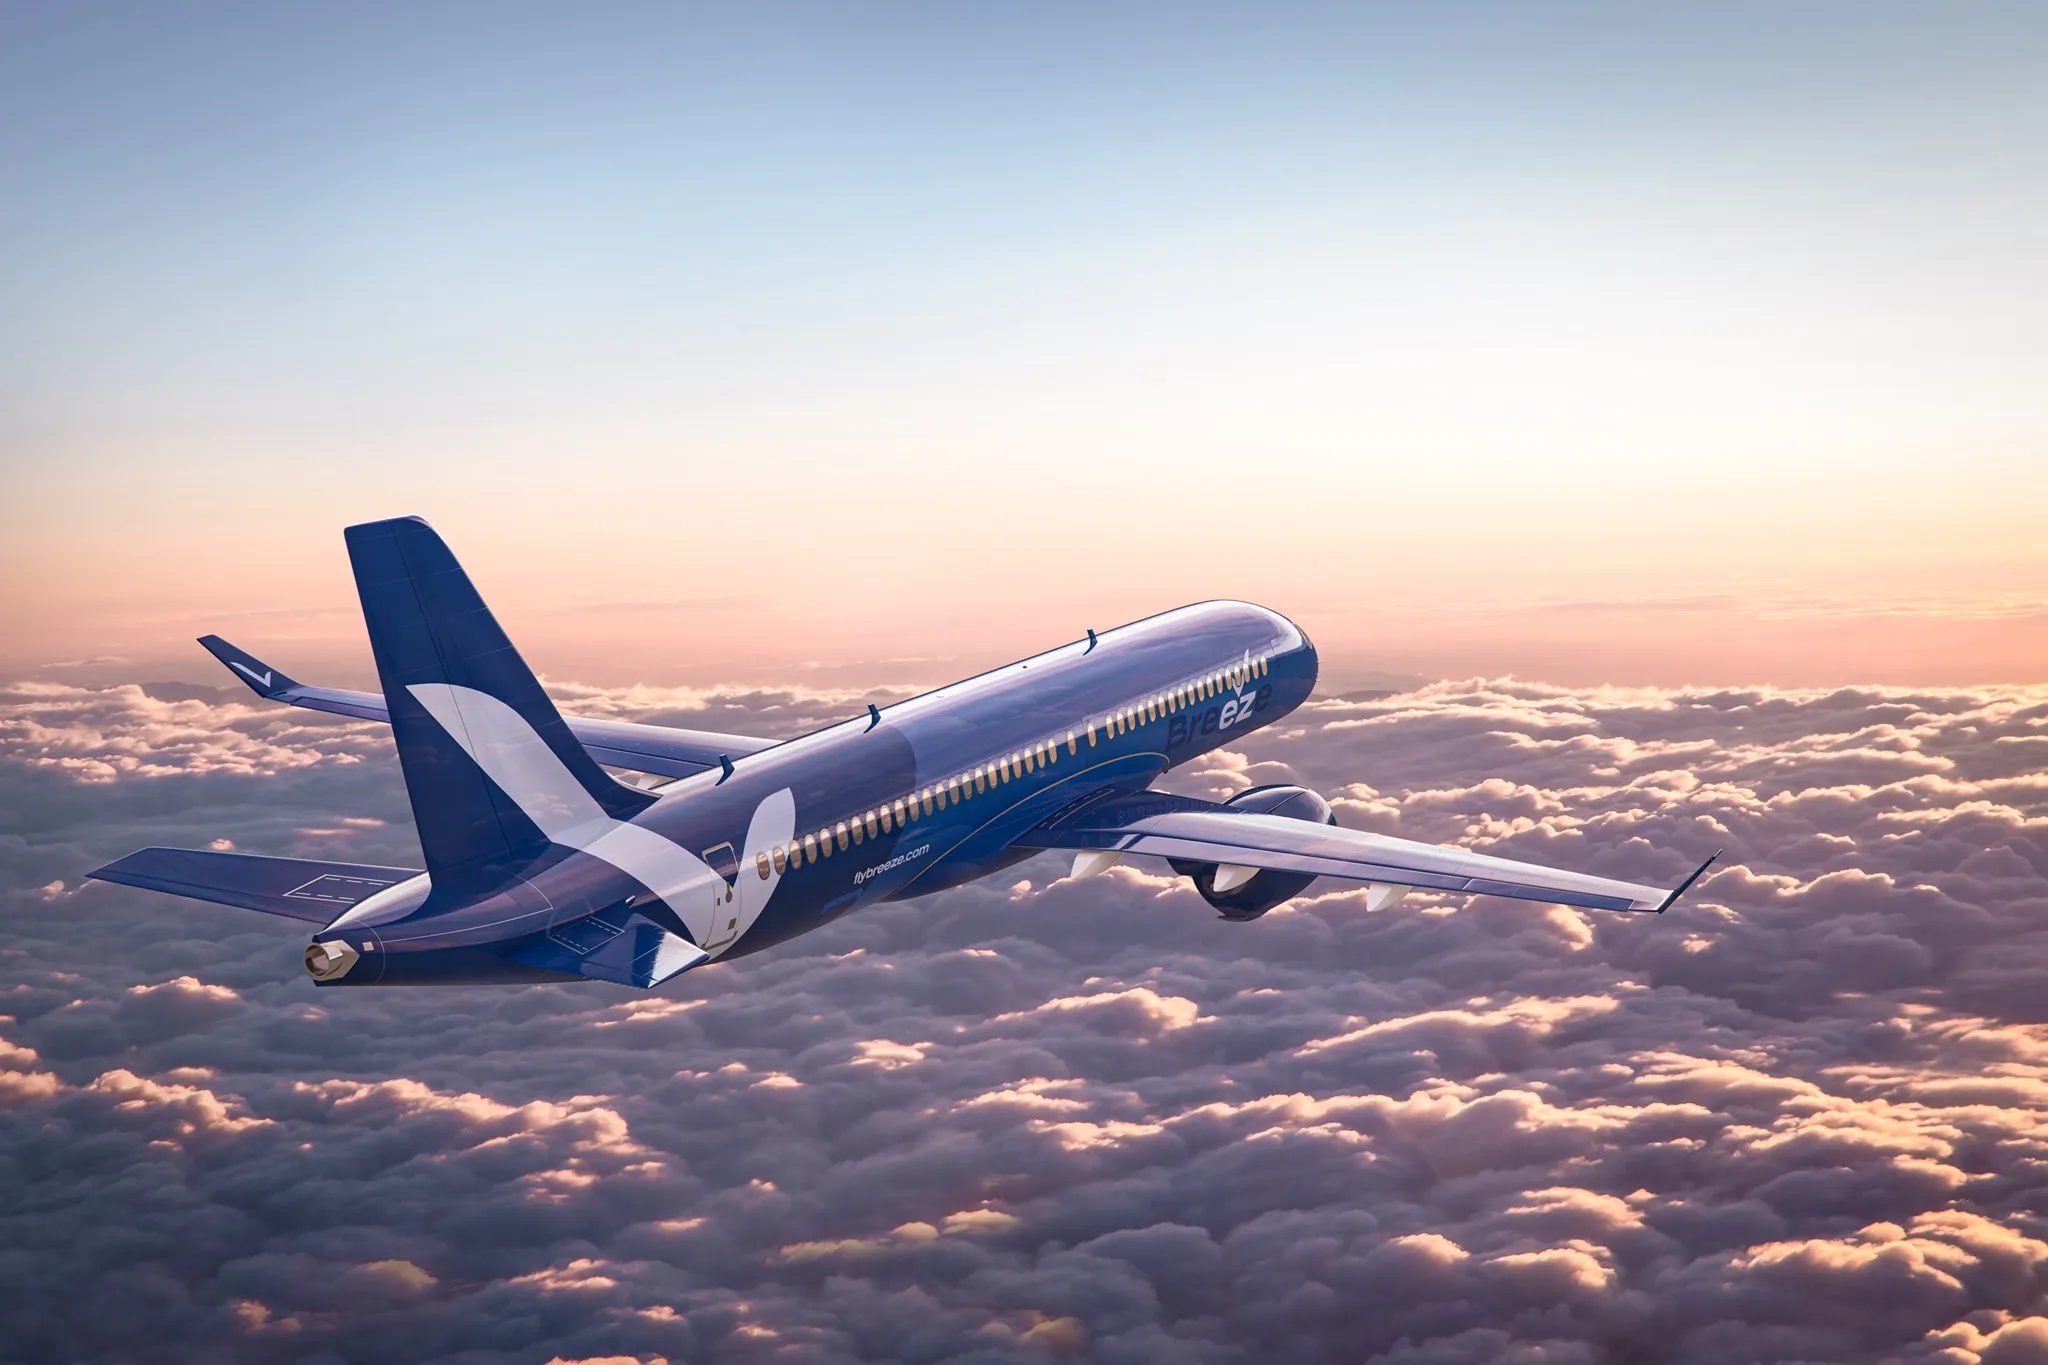

### Conect to Drive:

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Libraries:

In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from math import sqrt
import seaborn as sn
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import os
import warnings
warnings.filterwarnings("ignore")

## Class Design:

In [64]:
class Automatic_ML:

    def __init__(self):
      """ We define the class
      """
      pass


    def ReadData(path='./data.csv', train_test_to_split='yes', 
                     y_name = 'y', test_size=0.25, DataCleaning ='no'):
      """ This module is usefull for read the data we are going to predict.
          
          Inputs:
              - Path: The path were we have the dataframe.
              - train_test_to_split: We have two options:
                      1. "yes" if we don't have a separated data sets of 
                          X_train, y_train, X_test and y_test.
                      2. "no" if we already have  X_train, y_train, X_test and 
                          y_test in our directroy.

              - y_name if we select train_test_to_split = "yes", we should
              define here the name of the varaible to predict.
              - test_size: test size to divide train/test.
              - DataCleaning: Here we can add things we need to do
              to have the data in the desired format. By default, the function 
              will not enter that part of the code (DataCleaning ='no'). If we
              select DataCleaning ='yes', the nmodule enter in the part to clean
              the data. 

          Return:
              X_train, y_train, X_test, y_test
      """

      if train_test_to_split =='yes':
        data =  pd.read_excel(str(path))
        X = data.drop(columns=[str(y_name)])
        y = data[str(y_name)]
          
        # using the train test split function
        X_train, X_test,
        y_train, y_test = train_test_split(X, y,
                                          random_state=0, 
                                          test_size=test_size, 
                                   shuffle=True)


      if train_test_to_split == 'no':
        X_train = pd.read_csv(str(path) + 'X_train.csv')
        y_train = pd.read_csv(str(path) + 'y_train.csv')
        X_test = pd.read_csv(str(path) + 'X_test.csv')
        y_test = pd.read_csv(str(path) + 'y_test.csv')


      # Here we can add more code to clean the data and have it in the desired 
      # format. It will depend on the problem and the data what we have to 
      # design here. 

      if DataCleaning == 'yes':
        # In our case, we need to drop ids.
        y_train = y_train['price']
        y_test = y_test['price']
        X_train.drop(columns = ['filghtId'], inplace=True)
        X_test.drop(columns = ['filghtId'], inplace=True) 

      return X_train, y_train, X_test, y_test



    def NumericalPreprocessing(X_train, X_test):
      """ This class preprocesses the numerical data, making three settings: 
      standard, robust and minmax. 

          Inputs:
              - X_train and X_test

          Return:
              - X_train standard, X_train robust and X_train minmax.
              - X_test standard, X_test robust and X_test minmax. 
      """

      numcol = X_train.select_dtypes(exclude='object').columns

      for i in numcol:
        # Robust Scaler
        scaler_rob = RobustScaler()
        X_train_rob = X_train.copy()
        X_test_rob = X_test.copy()

        scaler_rob.fit(pd.concat([X_train[i], X_test[i]], axis=0).values.reshape(-1,1))
        X_train_rob[i] = scaler_rob.transform(X_train[i].values.reshape(-1,1))
        X_test_rob[i] = scaler_rob.transform(X_test[i].values.reshape(-1,1))

        # Standard Scaler
        scaler_std = StandardScaler()
        X_train_std = X_train.copy()
        X_test_std = X_test.copy()

        scaler_std.fit(pd.concat([X_train[i], X_test[i]], axis=0).values.reshape(-1,1))
        X_train_std[i] = scaler_std.transform(X_train[i].values.reshape(-1,1))
        X_test_std[i] = scaler_std.transform(X_test[i].values.reshape(-1,1))

        # MinMaxScaler
        scaler_mm = MinMaxScaler()
        X_train_mm = X_train.copy()
        X_test_mm = X_test.copy()

        scaler_std.fit(pd.concat([X_train[i], X_test[i]], axis=0).values.reshape(-1,1))
        X_train_mm[i] = scaler_std.transform(X_train[i].values.reshape(-1,1))
        X_test_mm[i] = scaler_std.transform(X_test[i].values.reshape(-1,1))

      return X_train_rob, X_test_rob, X_train_std, X_test_std, X_train_mm, X_test_mm



    def CategoricalPreprocessing(X_train, X_test):
      """ This class preprocesses categorical data using Labelencoding.

          Inputs:
              - X_train and X_test

          Return:
              - X_train and X_test without categorical variables.       
      """

      catcol = X_train.select_dtypes(include='object').columns
      Dummy = False
      for j in catcol:
          encoder = LabelEncoder()
          encoder.fit(pd.concat([X_train[j], X_test[j]], axis=0).values.ravel())
          X_train[j] = encoder.transform(X_train[j].values.ravel())
          X_test[j] = encoder.transform(X_test[j].values.ravel())
          
          if Dummy == True:
              X_train = pd.concat([X_train, pd.get_dummies(X_train[i], prefix=j)], axis=1)
              X_test = pd.concat([X_test, pd.get_dummies(X_test[i], prefix=j)], axis=1)
              print(j,'::',X_train[j].unique())

              X_train.drop(columns=[j], inplace=True)
              X_test.drop(columns=[j], inplace=True)

      return X_train, X_test



    def PCA_Reduction(X_train, X_test, comp_pca):
      """ This function reduces by Principal Component Analysis 
      the dimensionality of the data.

          Inputs:
              - X_train and X_test
              - Number of PCA components. Reduction dimension.

          Return:
              - X_train and X_test reduced by pca.
      """
      # We define the PCA.
      model_pca = PCA(n_components=comp_pca)

      # We train and transform the dimension.
      X_train_red = model_pca.fit_transform(X_train)
      X_test_red = model_pca.transform(X_test)

      return X_train_red, X_test_red



    def train_test_modelo(X_train, X_test, y_train, y_test, model):
      """ This function trains the model and returns the prediction.

          Inputs:
              - X_train and X_test.
              - y_train and y_test.
              - Model we want to train

          Return:
              - Prediction of the model
      """

      # Train
      model.fit(X_train, y_train)

      # Prediccion
      y_pred = model.predict(X_test)
      
      return y_pred



    def Pipeline(model, X_train, X_test, y_train, y_test, 
                 n_comps_test = [2,4,6,8,'PCA_no']):
      
      """ This function, given a model, tests the different preprocessing. 
      
      It follows the following steps:
          
          1. Preprocess the numerical data, then the categorical data. 
          2. For each standardized set (standardized, robust, minmax and 
          unstandardized data, robust, minmax and unstandardized data):
            2.1. Perform a PCA of 2,4,6,8 or all components. For each of these
                 data sets:
                 2.1.1 The model is trained and predicted with each of the 
                       ensembles.
                 2.1.2. We store by R2, MAE and RMSE the goodness of fit of the 
                      results together with the preprocessed.
          
          # For example, following the parameters defined by defects, we have 
          n_comps_test = [2,4,6,8,'PCA_no'], then we would perform 3 
          standardizations (standard, robust, minmax i without standardization). 
          For each of these sets, we apply a PCA of 2,4,6,8 i all components, 
          which makes a total of 5 x 5 = 25 sets with different preprocessing 
          tested.

          Inputs:
              - Model
              - X_train, X_test, y_train, y_test.
              - n_comps_test: list of PCA components we want to test.

          Return:
              - A dataframe with the results sorted from best to worst 
              according to their preprocessing.
        
      """      

      data_results_pca = pd.DataFrame(columns=['Standarization','Dim_reduction', 
                                               'R2_test', 'MAE_test', 'RMSE_test'])
      # categorical
      X_train_rob, X_test_rob, X_train_std, X_test_std, X_train_mm, X_test_mm = Automatic_ML.NumericalPreprocessing(X_train, X_test)
      for normalization in range(1, 5):
        if normalization == 1:
          X_train_tf, X_test_tf = Automatic_ML.CategoricalPreprocessing(X_train_rob, X_test_rob)
          name_norm = str('Robust')

        if normalization == 2:
          X_train_tf, X_test_tf = Automatic_ML.CategoricalPreprocessing(X_train_std, X_test_std)
          name_norm = str('Standard')

        if normalization == 3:
          X_train_tf, X_test_tf = Automatic_ML.CategoricalPreprocessing(X_train_mm, X_test_mm)
          name_norm = str('MinMax')
        
        if normalization == 4:
          X_train_tf, X_test_tf = Automatic_ML.CategoricalPreprocessing(X_train, X_test)
          name_norm = str('No_Norm')

        # PCA Reduction:
        for comp_pca in n_comps_test:
          name_dim = str(comp_pca)

          if comp_pca == 'PCA_no':
            X_train_final = X_train_tf
            X_test_final = X_test_tf
            
          else:
            X_train_final, X_test_final = Automatic_ML.PCA_Reduction(X_train_tf, X_test_tf, comp_pca=comp_pca)

          y_pred = Automatic_ML.train_test_modelo(X_train_final, X_test_final, y_train, y_test, model)
          r2_test = r2_score(y_test, y_pred)
          mae_test = mae(y_test, y_pred)
          rmse_test = sqrt(mse(y_test, y_pred))

          final_results = [
              str(name_norm),
              str(name_dim),
              float(r2_test),
              float(mae_test),
              float(rmse_test)]

          data_results_pca.loc[len(data_results_pca)] = final_results
          bestresults = Automatic_ML.OrderBestsResults(data_results_pca)

      return bestresults


    def OrderBestsResults(data_results):
      """ This function sorts the dataframe of the model results according to 
      the R2 metric in test set and wich preprocessing techinque is used in that
      case.
          
          Inputs:
              - Results of the model obtained in the previous module.

          Return:
              - Ordered results dataframe.
      """
      data_res1 = data_results.groupby(['Standarization','Dim_reduction']).mean()
      data_res1 = data_res1.sort_values(by='R2_test',ascending=False)

      return data_res1



    def Best_Model_Selection(bestresults, model, X_train, X_test, y_train, y_test):
      """This function selects the best preprocessing and dimensionality 
      reduction. Subsequently, it trains the model with the best techinques and 
      returns the prediction.

          Inputs:
              - bestresults obtained in previous module.
              - model, X_train, X_test, y_train, y_test

          Return:
              - Prediction using the best techinque.
      """
      norm = bestresults.head(1).index[0][0]
      red = bestresults.head(1).index[0][1]
        
      X_train_rob, X_test_rob, X_train_std, X_test_std, X_train_mm, X_test_mm = Automatic_ML.NumericalPreprocessing(X_train, X_test)

      if norm == 'Robust':
        X_train_tf, X_test_tf = Automatic_ML.CategoricalPreprocessing(X_train_rob, X_test_rob)

      if norm == 'Standard':
        X_train_tf, X_test_tf = Automatic_ML.CategoricalPreprocessing(X_train_std, X_test_std)

      if norm == 'MinMax':
        X_train_tf, X_test_tf = Automatic_ML.CategoricalPreprocessing(X_train_mm, X_test_mm)

      if norm =='No_Norm':
        X_train_tf, X_test_tf = Automatic_ML.CategoricalPreprocessing(X_train, X_test)

      if red == 'PCA_no':
        X_train_final = X_train_tf
        X_test_final = X_test_tf

      else:
        X_train_final, X_test_final = Automatic_ML.PCA_Reduction(X_train_tf, X_test_tf, comp_pca=int(red))

      y_pred = Automatic_ML.train_test_modelo(X_train_final, X_test_final, y_train, y_test, model)
      return y_pred


    def ModelEvaluation (ytest, ypred):
      """This function prints the different metrics on the screen:
      RMSE, MAE and R2. In addition, we can see different graphs on the 
      residuals of the model. It is used to evaluate the performance of the 
      model.

          Inputs:
              - y_test and y_pred

          Return:
              - Print performance in screen
      """

      print('TEST')
      print('R2 =  ', r2_score(ytest, ypred))
      print('MAE =  ', mae(ytest, ypred))
      print('RMSE = ', sqrt(mse(ytest, ypred)))
      print('-'*47)

      residuos = ypred - ytest

      fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 8))

      axes[0, 0].scatter(ytest, ypred, edgecolors=(0, 0, 0), alpha = 0.4)
      axes[0, 0].plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()],
                      'k--', color = 'black', lw=2)
      axes[0, 0].set_title('Valor predit vs valor real', fontsize = 10, fontweight = "bold")
      axes[0, 0].set_xlabel('Real')
      axes[0, 0].set_ylabel('Predicció')
      axes[0, 0].tick_params(labelsize = 7)

      axes[0, 1].scatter(list(range(len(ytest))), residuos,
                        edgecolors=(0, 0, 0), alpha = 0.4)
      axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
      axes[0, 1].set_title('Residus del model', fontsize = 10, fontweight = "bold")
      axes[0, 1].set_xlabel('id')
      axes[0, 1].set_ylabel('Residuo')
      axes[0, 1].tick_params(labelsize = 7)


      sm.qqplot(
          residuos,
          fit   = True,
          line  = 'q',
          ax    = axes[1, 1], 
          color = 'firebrick',
          alpha = 0.4,
          lw    = 2
      )
      axes[1, 1].set_title('Q-Q residus del model', fontsize = 10, fontweight = "bold")
      axes[1, 1].tick_params(labelsize = 7)

      axes[1, 0].scatter(ypred, residuos,
                        edgecolors=(0, 0, 0), alpha = 0.4)
      axes[1, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
      axes[1, 0].set_title('Residus del model vs predicció', fontsize = 10, fontweight = "bold")
      axes[1, 0].set_xlabel('Predicción')
      axes[1, 0].set_ylabel('Residuo')
      axes[1, 0].tick_params(labelsize = 7)

      fig.tight_layout()
      plt.subplots_adjust(top=0.9)



    def Automaticaly(path='./data.csv', train_test_to_split='yes', 
                     y_name = 'y', test_size=0.25,
                     DataCleaning = 'no', 
                     n_comps_test=[2,4,6,8,'PCA_no'],
                     model= LinearRegression(),
                     save_results='no'):
      
      """ This module automates the entire process seen above. Steps:
            1. Reads the data, 
            2. Executes the preprocessing with the Pipeline module. 
            3. It executes the best model found with the previously executed module.
            4. Display the performance of the model.

            Inputs:
              - Path: The path were we have the dataframe.
              - train_test_to_split: We have two options:
                      1. "yes" if we don't have a separated data sets of 
                          X_train, y_train, X_test and y_test.
                      2. "no" if we already have  X_train, y_train, X_test and 
                          y_test in our directroy.

              - y_name if we select train_test_to_split = "yes", we should
              define here the name of the varaible to predict.
              - test_size: test size to divide train/test.
              - DataCleaning: Here we can add things we need to do
              to have the data in the desired format. By default, the function 
              will not enter that part of the code (DataCleaning ='no'). If we
              select DataCleaning ='yes', the nmodule enter in the part to clean
              the data. 
              - n_comps_test: list of PCA components we want to test.
              - Model we want to test.
              - Save Results: If we put yes, save in a new folder called 
              ModelPerformance the results obtained by a model.

          Return:
              Model performance graphs and metrics.
      """

      # We read the data using the first module
      X_train, y_train, X_test, y_test = Automatic_ML.ReadData(path=path, 
                                                               train_test_to_split=train_test_to_split,
                                                               y_name=y_name, test_size=test_size,
                                                               DataCleaning=DataCleaning)

      # We execute the pipline to obtain the best preprocesing techinque
      bestresults = Automatic_ML.Pipeline(model, X_train, X_test, y_train, y_test, 
                                           n_comps_test = n_comps_test)
      
      # export to csv if save_results=='yes'.
      if save_results=='yes':
        if not os.path.exists("./ModelPerformance/"):
          os.makedirs("./ModelPerformance/")  
        bestresults.to_csv('./ModelPerformance/' + str(model) + '_results.csv') 


      # We display on screen the best model obtained performance:
      y_pred = Automatic_ML.Best_Model_Selection(bestresults, model, X_train,
                                                 X_test, y_train, y_test)
      
      y_test = np.array(y_test)
      
      Automatic_ML.ModelEvaluation(y_test, y_pred)

## Prueba diferentes modelos:

### Linear Regression:

TEST
R2 =   0.3828068495243685
MAE =   7831.906824116983
RMSE =  10454.59352967143
-----------------------------------------------


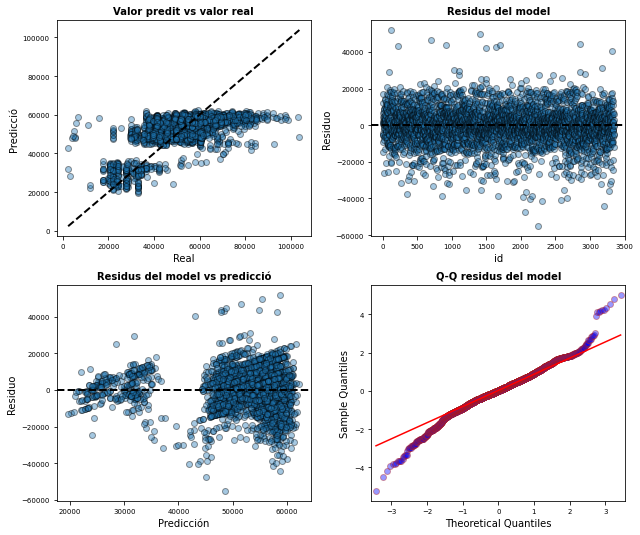

In [57]:
Automatic_ML.Automaticaly(path='/content/gdrive/MyDrive/Master IA/Eines IA/',
                          train_test_to_split='no',
                          DataCleaning='yes',
                          n_comps_test = [2,4,6,8,'PCA_no'],
                          model= LinearRegression(),
                          save_results='yes')

### Random Forest Regressor

TEST
R2 =   0.816188569318934
MAE =   3122.63190419281
RMSE =  5705.357479726949
-----------------------------------------------


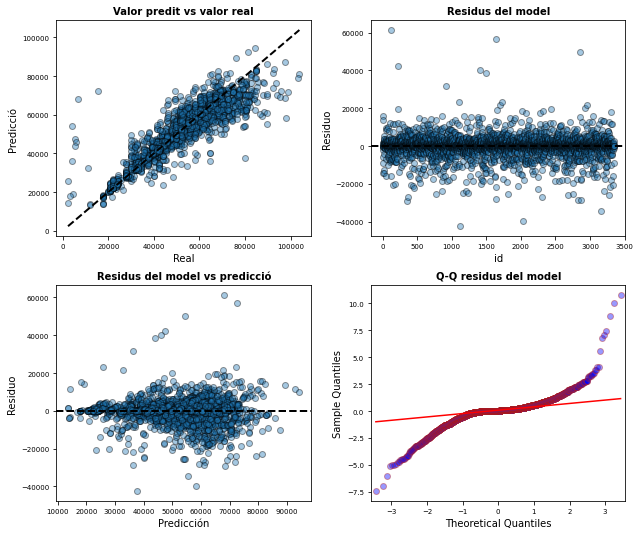

In [58]:
Automatic_ML.Automaticaly(path='/content/gdrive/MyDrive/Master IA/Eines IA/',
                          train_test_to_split='no',
                          DataCleaning='yes',
                          n_comps_test = [2,4,6,8,'PCA_no'],
                          model= RandomForestRegressor(random_state=0),
                          save_results='yes')

### Extra Trees Regressor:

TEST
R2 =   0.8021516633664646
MAE =   2957.4943397072
RMSE =  5919.1971491021595
-----------------------------------------------


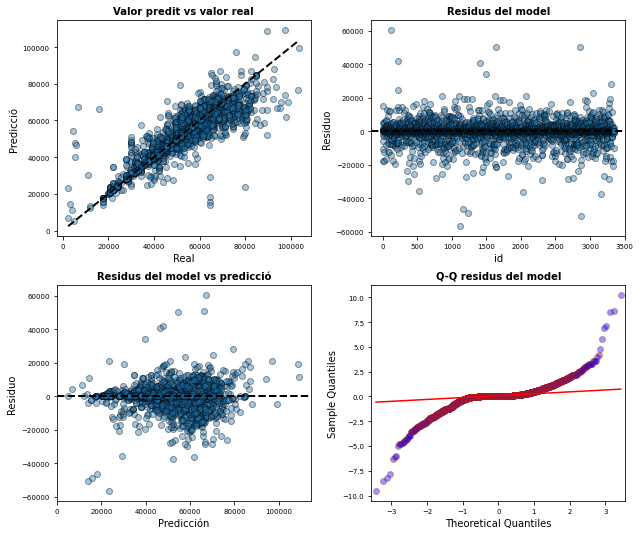

In [59]:
Automatic_ML.Automaticaly(path='/content/gdrive/MyDrive/Master IA/Eines IA/',
                          train_test_to_split='no',
                          DataCleaning='yes',
                          n_comps_test = [2,4,6,8,'PCA_no'],
                          model= ExtraTreesRegressor(random_state=0),
                          save_results='yes')

### XGB Regressor 

[08:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

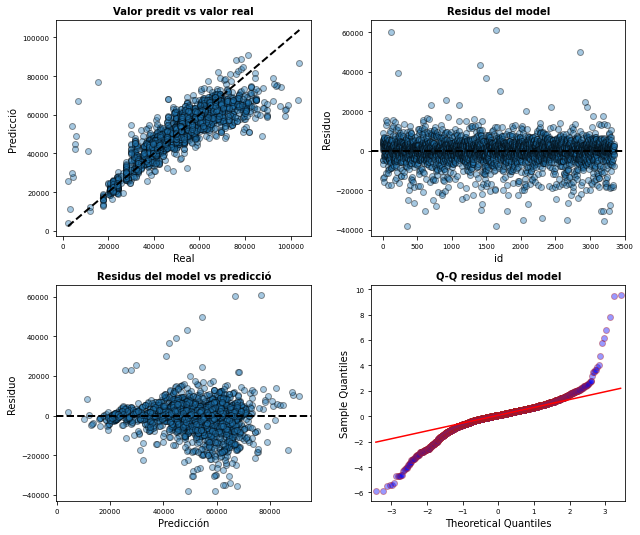

In [60]:
Automatic_ML.Automaticaly(path='/content/gdrive/MyDrive/Master IA/Eines IA/',
                          train_test_to_split='no',
                          DataCleaning='yes',
                          n_comps_test = [2,4,6,8,'PCA_no'],
                          model= XGBRegressor(n_estimators = 550 ,random_state=0),
                          save_results='yes')

### Ada Boost Regressor

TEST
R2 =   0.46921901959089496
MAE =   7393.288220848535
RMSE =  9695.144349409971
-----------------------------------------------


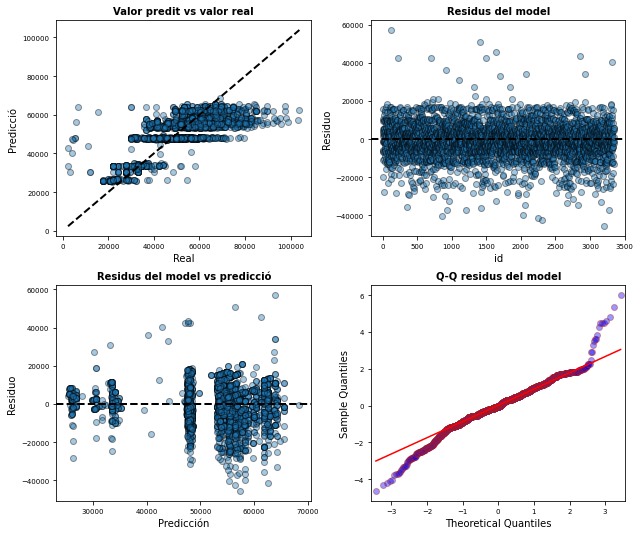

In [62]:
Automatic_ML.Automaticaly(path='/content/gdrive/MyDrive/Master IA/Eines IA/',
                          train_test_to_split='no',
                          DataCleaning='yes',
                          n_comps_test = [2,4,6,8,'PCA_no'],
                          model= AdaBoostRegressor(n_estimators=100, learning_rate=0.1,random_state=0),
                          save_results='yes')

### GradientBoostingRegressor

TEST
R2 =   0.7826549711927678
MAE =   3981.261051495275
RMSE =  6203.995285311852
-----------------------------------------------


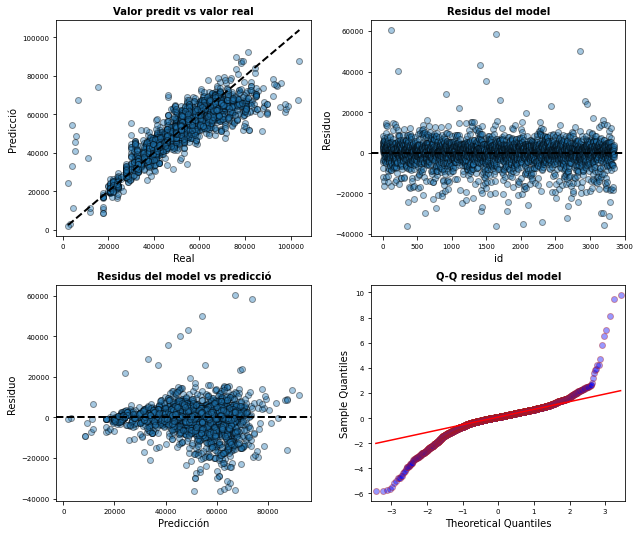

In [63]:
Automatic_ML.Automaticaly(path='/content/gdrive/MyDrive/Master IA/Eines IA/',
                          train_test_to_split='no',
                          DataCleaning='yes',
                          n_comps_test = [2,4,6,8,'PCA_no'],
                          model= GradientBoostingRegressor(n_estimators=750,random_state=0),
                          save_results='yes')